<a href="https://colab.research.google.com/github/ofer1992/dl-notes/blob/master/fastai_dl1/lesson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 2
## Quick Summary
Part 1 was the HW from last lesson, build your own dataset and train on it. Filter the data. 

Part 2 was building a linear regressor using SGD "from scratch", using pytorch.

Again, we talked about the top-down, code first approach. Learn from experiments, learn the whole game, start from concepts to details. We'll see how it comes to pass in this lesson.

## Building my own classifier

Following last week homework's assignment, which was confusingly explained in today's lesson, I created [my own classifier](https://github.com/ofer1992/dl-notes/blob/master/fastai_dl1/lesson1_hw.ipynb) for airport interiors.

There are some descriptions in the notebook and the notes for lesson 1. It's up to debate whether to be more verbose and write it as a story [this blogpost](https://blog.usejournal.com/if-i-can-you-can-and-you-should-a470d7aea89d), or keep it lean and mean. I'll give a try to the storyteller approach, if anything, just because it's more fun.

The first part of the lesson was going over lesson2-download.ipynb, which kinda takes you through the same process by building a (teddy, grizzly, black) bear classifier. Gathering the data, which is important and often overlooked, taking a look to see it makes sense, training the model. At this part there's a little bit of puzzlement over the "black magic". fastai leaves you with two parameters to fuss about, learning rate and epoch number.

Learning rate determines how aggresive the optimization is. A rule-of-thumb number Jeremy uses is 3e-3. To be more specific, in the first stage, where we only train the network head, he'll use 3e-3. Later, after we unfreeze the weights, we plot the learning rate finder results and choose the confine the limit to the area with the strongest and longest downward slope.

Epochs is the number of times the learner will see the data. Too few epoches mean we haven't extracted all meaning out of our data, and our training loss will be high, too much, and we are overfitting, and the validation loss will start to climb. Contrary to popular perception, Jeremy claims learning loss should always be lower than validation loss.

Once we feel satisfied we interpert the result. The confusion matrix and top losses are worth a look. We might decide to clean up the data, or find more samples, or try a different architecture. Surprisingly, cleaning up the data will usually have a negligible effect, since these networks are pretty good at accounting for noise (as long as it's not biased, then it's a different story).

The last part here was to build a production worthy classifier. I kinda skipped this part, although it can be fun to learn something new. Perhaps in the future.

## SGD and Linear Regression

Neural nets are just a mathematical function from tensors to tensors, and so is a linear regression. Of course, one tiny difference is that a simple 2-dimensional linear regression will have twp parameters where a neural network can have fifty million, but still, there is a lot to be gleaned from the comparison.

Jeremy sneakingly introduced linear regression in an unassuming way, starting from the equation $y = ax + b$ and after some simple renamings and notation we arrived at a fitting problem. I wonder how it feels to be exposed to the problem this way. One question the might arise is why are the points not on the line? because of noise! but we don't really talk about it.

After all that massaging, we succesfully transform $y = ax + b$ to $\vec{y} = X\vec{a}$, which is good, because computers love linear algebra. It's the thing they're best at. Now we can dive into the code.


In [1]:
!curl -s https://course.fast.ai/setup/colab | bash
%matplotlib inline
from fastai.basics import *

Updating fastai...
Done.


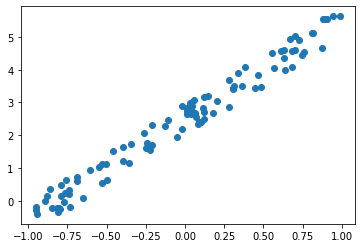

In [5]:
n=100
# 85% percent of all pytorch is in these 4 lines
x = torch.ones(n,2) 
x[:,0].uniform_(-1.,1)
x[:5]
a = tensor(3.,2);
y = x@a + torch.rand(n); y[:5]
plt.scatter(x[:,0], y);

What just happened? We simply generated some synthetic data, from a line, and added some uniformly distributed noise. Notice the `@` symbol, can be used for matrix multiplications., also, the underscore in `uniform_` tells us this method modifies the object it's applied on.

We have the data, now comes the question, how can we tell if a give line is a good model for it? Well, we need an _error function_ or a _loss function_!

Heres one:

In [0]:
def mse(y_hat, y): return ((y_hat-y)**2).mean()

The mean squared error, or **MSE**.

So we have a loss function, now what? how do we actually get the answer. It turns out that for linear regression, there is a closed form solution, meaning there is a formula where you can put the data in one side and get the optimal parameters for the MSE in the other side. But this only works for linear regression with this kind of loss function. We will see a more general technique called "Stochastic Gradient Descent", or SGD for short. The idea is, we start from some guess of the parameters, and improve it somehow. To answer that, let's first see some more code:

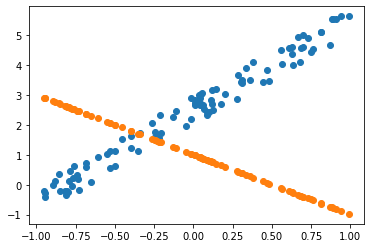

In [7]:
a = tensor(-2.,1) # now a is the guess
y_hat = x@a # our predictions according to the guess
mse(y_hat, y)
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],y_hat);

Obviously that's a pretty bad guess. What we will do is look at the gradient, or derivative, of the loss function with respect to our parameters. The gradient gives us the direction vector of steepest ascent, so we can just "walk" the other way and get the steepest descent, and we should get a lower loss value. And in code

In [0]:
# a, lr will be defined later.
def update():
    y_hat = x@a
    loss = mse(y, y_hat)
    if t % 10 == 0: print(loss)
    loss.backward() # calculate the gradient of loss
    with torch.no_grad():
        a.sub_(lr * a.grad)
        a.grad.zero_()

There's a bit of pytorch magic going on here. One nifty trick is that pytorch automatically does all the gradient calculations for us. Infact, when loss is printed we can see a description of it's gradient.

Another curious guest is `lr` in `a.sub_(lr * a.grad)`. Who might it be? Well, the learning rate of course! It is literally a magnitude coefficient for the gradient. With a bigger learning rate, we follow the gradient for longer and vice-versa. Let's train!

In [20]:
a = nn.Parameter(tensor(-1.,1))
lr = 1e-1
for t in range(100): update()

tensor(7.2192, grad_fn=<MeanBackward0>)
tensor(1.5425, grad_fn=<MeanBackward0>)
tensor(0.4751, grad_fn=<MeanBackward0>)
tensor(0.1886, grad_fn=<MeanBackward0>)
tensor(0.1103, grad_fn=<MeanBackward0>)
tensor(0.0889, grad_fn=<MeanBackward0>)
tensor(0.0830, grad_fn=<MeanBackward0>)
tensor(0.0814, grad_fn=<MeanBackward0>)
tensor(0.0810, grad_fn=<MeanBackward0>)
tensor(0.0809, grad_fn=<MeanBackward0>)


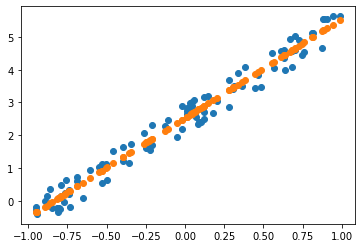

In [21]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],(x@a).detach());

Looks like we got a pretty nice convergence. Before we finish, let's check a couple more scenarios:

tensor(11.0429, grad_fn=<MeanBackward0>)
tensor(1.5542, grad_fn=<MeanBackward0>)
tensor(0.5090, grad_fn=<MeanBackward0>)
tensor(0.2098, grad_fn=<MeanBackward0>)
tensor(0.1182, grad_fn=<MeanBackward0>)
tensor(0.0901, grad_fn=<MeanBackward0>)
tensor(0.0814, grad_fn=<MeanBackward0>)
tensor(0.0788, grad_fn=<MeanBackward0>)
tensor(0.0780, grad_fn=<MeanBackward0>)
tensor(0.0777, grad_fn=<MeanBackward0>)


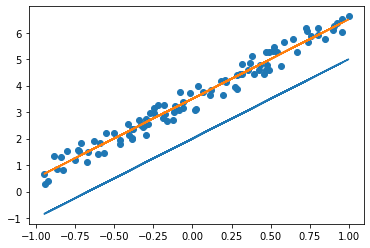

In [23]:
# what happens when the noise is biased?
n=100
x = torch.ones(n,2) 
x[:,0].uniform_(-1.,1)
a = tensor(3.,2);
y = x@a + 1 + torch.rand(n);
a_original = a # let's save our original a
a = nn.Parameter(tensor(-1.,1))
lr = 1e-1
for t in range(100): update()
plt.scatter(x[:,0], y)
plt.plot(x[:,0], (x@a_original).detach())
plt.plot(x[:,0], (x@a).detach())

Since all our samples were shifted by 1, we have biased noise, and the regression cannot recover the original parameters. Now, this is a little simplistic, but who hasn't had an uncalibrated weighing scale?

Let's see another one

tensor(48.3747, grad_fn=<MeanBackward0>)
tensor(11.2247, grad_fn=<MeanBackward0>)
tensor(9.3490, grad_fn=<MeanBackward0>)
tensor(8.9895, grad_fn=<MeanBackward0>)
tensor(8.9070, grad_fn=<MeanBackward0>)
tensor(8.8880, grad_fn=<MeanBackward0>)
tensor(8.8836, grad_fn=<MeanBackward0>)
tensor(8.8825, grad_fn=<MeanBackward0>)
tensor(8.8823, grad_fn=<MeanBackward0>)
tensor(8.8822, grad_fn=<MeanBackward0>)


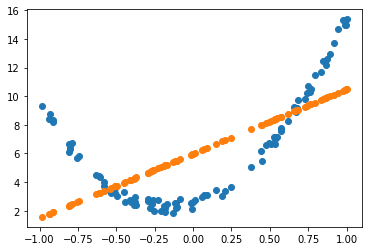

In [27]:
# what happens when the model can't explain the data
n=100
x = torch.ones(n,3) 
x[:,1].uniform_(-1.,1)
x[:,0] = x[:,1]**2
a = tensor(10., 3.,2);
y = x@a + torch.rand(n);
a_original = a # let's save our original a
a = nn.Parameter(tensor(-1.,1))
x = x[:,1:]
lr = 1e-1
for t in range(100): update()
plt.scatter(x[:,0], y);
plt.scatter(x[:,0], (x@a).detach())

Our data was generated by a quadratic function, so it obviously cannot be predicted by a line. Here is a case where our model is inadequate for describing the data.

The astute reader will notice that even though the data is quadratic, it is generated using matrix multiplication, and can be fitted using linear regression with the right modifications. A little counterintuitive, but fun result.

Ohh, and one last note. Where's the stochastic part? In this example we actually use "vanilla" gradient descent, since we only had a hundred data points. When we train DNNs, we might have a million and a half images. Just calculating the loss function would take too long. Instead we used mini-batches, randomly select a subset of the data and calculate the loss and the gradient on it. Turns out the difference in results is small.

Lastly, here's a cool snippet for visualizing the training with an animation. Particulary enlightening for seeing the effect of the learning rate.

In [0]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [16]:
a = nn.Parameter(tensor(-1.,1))
lr = 1e-1
fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
bplt.close()
t = 1
def animate(i):

    update()
    line.set_ydata((x@a).detach())
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=20)

tensor(1.7540, grad_fn=<MeanBackward0>)
tensor(0.5297, grad_fn=<MeanBackward0>)
tensor(0.2035, grad_fn=<MeanBackward0>)
tensor(0.1144, grad_fn=<MeanBackward0>)
tensor(0.0900, grad_fn=<MeanBackward0>)
tensor(0.0833, grad_fn=<MeanBackward0>)
tensor(0.0815, grad_fn=<MeanBackward0>)
tensor(0.0810, grad_fn=<MeanBackward0>)
tensor(0.0809, grad_fn=<MeanBackward0>)
tensor(0.0808, grad_fn=<MeanBackward0>)


## Closing thoughts

That was fun little piece of math. Now, although we built the regressor in more of a bottom-up fashion, we still focused on the concepts rather than the details. In fact, under careful consideration one might find a variety of questions to be asked such as:
- why is the error in the y-axis and not orthogonal? a change of coordinate system will lead to different results?
- more generally, why this particular loss function? (one reason: it's differentiable)
- how is the gradient actually calculated?
- how do we choose our initial guess and does it matter?

Each of these can warrant a discussion, and at one point or another, depending on the task at hand you might have to confront them. For now though, we should understand the general picture, be comfortable with the fact that it works and that we don't understand all there is to know, and if there is some itch to scratch, just run an experiment like the ones above and see what happens.

One last note regarding overfitting and underfitting - We saw an example of underfitting with the quadratic data. The opposite can happen as well, as in the following example:: ![alt text](https://github.com/hiromis/notes/raw/master/lesson2/40.png)
On the right we have a model with too many parameters, it fits the data but obviously doesn't represent the trend. The best way to figure out where you stand on this axis is using a validation set, a set of examples your model hasn't been trained on, on which you would calculate the loss to see how it performs. Infact, validation sets is the thing to learn about if you don't understand AI but you want to judge it's use in your domain or product. There's a lot to know about how to choose validation sets, but that will be covered later in the course. Statisticans might say the problem arises from having too many parameters, but what about DNNs which surely have "too many" parameters? In practice, the way to prevent overfit is to use a something called regularization, which we will also learn about later.

